# SkinLesion - Desafio ISIC 2019 - EfficientNets
Pré-treinadas com o ImageNet.

## Pipeline checklist

1. *Path* do modelo a ser carregado;
2. Configurações da *learning rate*;
3. Épocas de treinamento (inicial e final);
4. Nome do modelo a ser salvo (número da época final).


## To do:


* Trocar **MICRO** F1-score por *weighted* F1-score:
  * Da forma como a média micro é implementada, seus resultados são iguais (literalmente, os mesmos) aos da acurácia.
*   List item



## Imports

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow_addons as tfa

Abertura dos dataframes

In [6]:
# Open dataframes containing the images for training, validation and test
train_df = pd.read_csv(
    r"./dataframes/isic2019_train.csv")

aug_df = pd.read_csv(
    r"./dataframes/isic2019_train_aug1_oversampled.csv")

val_df = pd.read_csv(
    r"./dataframes/isic2019_val.csv")

test_df = pd.read_csv(
    r"./dataframes/isic2019_test.csv")

## Treinamento da arquitetura EfficientNet-***B2***

### Dependências
#### Métricas

In [3]:
# Multiclass F1-score MACRO Avg.
macro_f1 = tfa.metrics.F1Score(
    num_classes=8,
    average='macro',
    name="Macro F1",
)

# Multiclass F1-score weighted (by the number of true instances in each class)
# average
weighted_f1 = tfa.metrics.F1Score(
    num_classes=8,
    average='weighted',
    name="Weighted F1",
)

2021-11-18 17:39:18.732293: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-18 17:39:18.732945: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-18 17:39:18.813377: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-18 17:39:18.814901: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1070 computeCapability: 6.1
coreClock: 1.797GHz coreCount: 15 deviceMemorySize: 7.93GiB deviceMemoryBandwidth: 238.66GiB/s
2021-11-18 17:39:18.814955: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-11-18 17:39:18.855815: I tensorflow/stream_executor/platform/default/d

#### Cálculo dos pesos das classes

In [5]:
# # Compute class' weights
# class_weights = compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(train_df.lesion),
#     y=train_df.lesion)

# class_weights = dict(enumerate(class_weights))

# print(class_weights)

{0: 3.651359143327842, 1: 0.9528697334479793, 2: 1.206518780620577, 3: 13.271706586826348, 4: 0.7002764612954187, 5: 0.2459359742565468, 6: 5.037215909090909, 7: 12.521892655367232}


### Geradores dos tensores (**B2**)

In [8]:
IMG_SIZE = 260
BATCH_SIZE = 32

train_dataGen = ImageDataGenerator(rescale=1./255)

train_generator = train_dataGen.flow_from_dataframe(
    dataframe=aug_df, x_col='image_path', class_mode='raw', seed=31415,
    y_col=['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC'],
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE)

val_generator = train_dataGen.flow_from_dataframe(
    dataframe=val_df, x_col='image_path', class_mode='raw', seed=31415,
    y_col=['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC'],
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE)

test_generator = train_dataGen.flow_from_dataframe(
    dataframe=test_df, x_col='image_path', class_mode='raw', seed=31415,
    y_col=['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC'],
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE)

Found 72946 validated image filenames.
Found 5066 validated image filenames.
Found 2534 validated image filenames.


### Instanciação da arquitetura

In [12]:
# # Load EfficientNet pre-trained w/ ImageNet
# base_model = EfficientNetB2(include_top=False, weights="imagenet")

# # Rebuild top
# avg = layers.GlobalAveragePooling2D(name="avg_pool")(base_model.output)
# norm = layers.BatchNormalization()(avg)
# dropout = layers.Dropout(0.35, name="top_dropout")(norm)
# output = layers.Dense(8, activation="softmax", name="pred")(dropout)

# model = tf.keras.Model(base_model.input, output, name="EfficientNetB2_Oversampled")

# # Freeze the pretrained weights
# for layer in base_model.layers:
#     layer.trainable = False

### Otimizador **SGD com Nesterov**

#### Treinamento das camadas superiores

In [13]:
# Load previous best weights
# model.load_weights(
#      '/content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_15top10').expect_partial()

# # Learning rate scheduler
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-3,
#     decay_steps=827*20,
#     decay_rate=0.1,
#     staircase=True)

# Freeze all layer's pretrained weights
for layer in model.layers[:-4]:
    layer.trainable = False

# Optimizer setup
optimizer = tf.keras.optimizers.SGD(
    learning_rate=5e-5, momentum=0.9, nesterov=True)

# Metrics
metrics = [CategoricalAccuracy(name='Categorical Accuracy'),
           macro_f1, weighted_f1]

# Compile model
model.compile(optimizer=optimizer, loss="categorical_crossentropy",
              metrics=metrics)

In [9]:
# Load FULL model
model = keras.models.load_model(
    "./models/oversampled/effNetB2_oversTop40")

In [16]:
# Save whole model based on validation loss
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "./models/oversampled/effNetB2_oversTop{epoch:02d}",
    monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=False, mode='min')

# Save model's history to '.csv' file
csv_logger = tf.keras.callbacks.CSVLogger(
    "./models/oversampled/effNetB2_oversHistory_cb.csv",
    separator=",",
    append=True)

In [17]:
# Top layers training: Epochs - min:8; max:80
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=60,
                    callbacks=[checkpoint, csv_logger],
                    initial_epoch=50)

Epoch 51/60
2280/2280 [==============================] - 608s 266ms/step - loss: 2.0691 - Categorical Accuracy: 0.1629 - Macro F1: 0.1504 - Weighted F1: 0.1502 - val_loss: 1.8893 - val_Categorical Accuracy: 0.5079 - val_Macro F1: 0.0845 - val_Weighted F1: 0.3428

Epoch 00051: val_loss improved from inf to 1.88926, saving model to ./models/oversampled/effNetB2_oversTop51
INFO:tensorflow:Assets written to: ./models/oversampled/effNetB2_oversTop51/assets


INFO:tensorflow:Assets written to: ./models/oversampled/effNetB2_oversTop51/assets


Epoch 52/60
2280/2280 [==============================] - 656s 288ms/step - loss: 2.0670 - Categorical Accuracy: 0.1656 - Macro F1: 0.1515 - Weighted F1: 0.1512 - val_loss: 1.8779 - val_Categorical Accuracy: 0.5079 - val_Macro F1: 0.0845 - val_Weighted F1: 0.3428

Epoch 00052: val_loss improved from 1.88926 to 1.87787, saving model to ./models/oversampled/effNetB2_oversTop52
INFO:tensorflow:Assets written to: ./models/oversampled/effNetB2_oversTop52/assets


INFO:tensorflow:Assets written to: ./models/oversampled/effNetB2_oversTop52/assets


Epoch 53/60
2280/2280 [==============================] - 654s 287ms/step - loss: 2.0656 - Categorical Accuracy: 0.1673 - Macro F1: 0.1514 - Weighted F1: 0.1512 - val_loss: 1.8825 - val_Categorical Accuracy: 0.5077 - val_Macro F1: 0.0844 - val_Weighted F1: 0.3427

Epoch 00053: val_loss did not improve from 1.87787
Epoch 54/60
2280/2280 [==============================] - 622s 273ms/step - loss: 2.0659 - Categorical Accuracy: 0.1657 - Macro F1: 0.1495 - Weighted F1: 0.1493 - val_loss: 1.8769 - val_Categorical Accuracy: 0.5077 - val_Macro F1: 0.0842 - val_Weighted F1: 0.3424

Epoch 00054: val_loss improved from 1.87787 to 1.87693, saving model to ./models/oversampled/effNetB2_oversTop54
INFO:tensorflow:Assets written to: ./models/oversampled/effNetB2_oversTop54/assets


INFO:tensorflow:Assets written to: ./models/oversampled/effNetB2_oversTop54/assets


Epoch 55/60
2280/2280 [==============================] - 645s 283ms/step - loss: 2.0634 - Categorical Accuracy: 0.1683 - Macro F1: 0.1515 - Weighted F1: 0.1513 - val_loss: 1.8797 - val_Categorical Accuracy: 0.5079 - val_Macro F1: 0.0845 - val_Weighted F1: 0.3428

Epoch 00055: val_loss did not improve from 1.87693
Epoch 56/60
2280/2280 [==============================] - 656s 287ms/step - loss: 2.0613 - Categorical Accuracy: 0.1709 - Macro F1: 0.1525 - Weighted F1: 0.1522 - val_loss: 1.8732 - val_Categorical Accuracy: 0.5079 - val_Macro F1: 0.0845 - val_Weighted F1: 0.3428

Epoch 00056: val_loss improved from 1.87693 to 1.87323, saving model to ./models/oversampled/effNetB2_oversTop56
INFO:tensorflow:Assets written to: ./models/oversampled/effNetB2_oversTop56/assets


INFO:tensorflow:Assets written to: ./models/oversampled/effNetB2_oversTop56/assets


Epoch 57/60
2280/2280 [==============================] - 638s 280ms/step - loss: 2.0619 - Categorical Accuracy: 0.1685 - Macro F1: 0.1513 - Weighted F1: 0.1511 - val_loss: 1.8703 - val_Categorical Accuracy: 0.5079 - val_Macro F1: 0.0845 - val_Weighted F1: 0.3428

Epoch 00057: val_loss improved from 1.87323 to 1.87027, saving model to ./models/oversampled/effNetB2_oversTop57
INFO:tensorflow:Assets written to: ./models/oversampled/effNetB2_oversTop57/assets


INFO:tensorflow:Assets written to: ./models/oversampled/effNetB2_oversTop57/assets


Epoch 58/60
2280/2280 [==============================] - 616s 270ms/step - loss: 2.0609 - Categorical Accuracy: 0.1702 - Macro F1: 0.1506 - Weighted F1: 0.1504 - val_loss: 1.8652 - val_Categorical Accuracy: 0.5079 - val_Macro F1: 0.0845 - val_Weighted F1: 0.3428

Epoch 00058: val_loss improved from 1.87027 to 1.86522, saving model to ./models/oversampled/effNetB2_oversTop58
INFO:tensorflow:Assets written to: ./models/oversampled/effNetB2_oversTop58/assets


INFO:tensorflow:Assets written to: ./models/oversampled/effNetB2_oversTop58/assets


Epoch 59/60
2280/2280 [==============================] - 610s 267ms/step - loss: 2.0594 - Categorical Accuracy: 0.1738 - Macro F1: 0.1536 - Weighted F1: 0.1534 - val_loss: 1.8570 - val_Categorical Accuracy: 0.5079 - val_Macro F1: 0.0845 - val_Weighted F1: 0.3428

Epoch 00059: val_loss improved from 1.86522 to 1.85704, saving model to ./models/oversampled/effNetB2_oversTop59
INFO:tensorflow:Assets written to: ./models/oversampled/effNetB2_oversTop59/assets


INFO:tensorflow:Assets written to: ./models/oversampled/effNetB2_oversTop59/assets


Epoch 60/60
2280/2280 [==============================] - 617s 271ms/step - loss: 2.0577 - Categorical Accuracy: 0.1732 - Macro F1: 0.1515 - Weighted F1: 0.1513 - val_loss: 1.8598 - val_Categorical Accuracy: 0.5079 - val_Macro F1: 0.0845 - val_Weighted F1: 0.3428

Epoch 00060: val_loss did not improve from 1.85704


In [10]:
# # Make new dataframe containing model's top training history
# top_history = pd.DataFrame.from_dict(history.history)
#
# # Save metrics' history as CSV
# top_history.to_csv(
#     "./models/nesterov/effNetB2_nesterovTopHistory.csv",
#     index=False)

In [18]:
# Save whole model with the top trained
model.save(
    "./models/oversampled/effNetB2_oversTop60")

INFO:tensorflow:Assets written to: ./models/oversampled/effNetB2_oversTop60/assets


INFO:tensorflow:Assets written to: ./models/oversampled/effNetB2_oversTop60/assets


##### Resultado do treinamento das camadas superiores

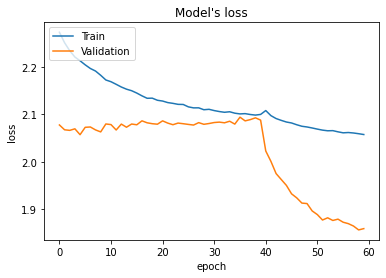

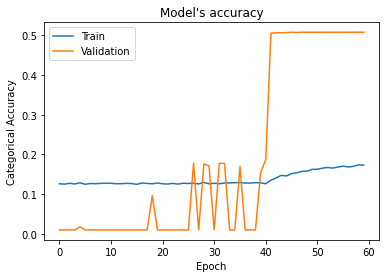

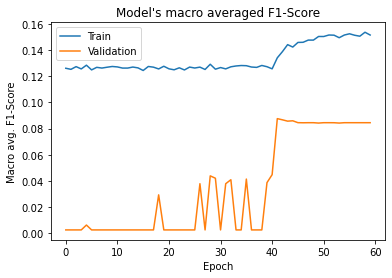

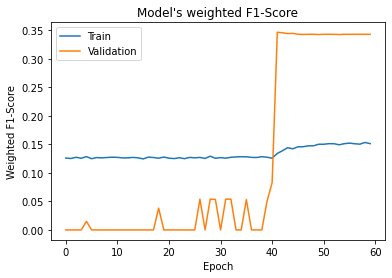

In [19]:
top_history = pd.read_csv(r"./models/oversampled/effNetB2_oversHistory_cb.csv")

# Summarize history for loss
plt.plot(top_history['loss'])
plt.plot(top_history['val_loss'])
plt.title('Model\'s loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
print()

# Summarize history for accuracy
plt.plot(top_history['Categorical Accuracy'])
plt.plot(top_history['val_Categorical Accuracy'])
plt.title('Model\'s accuracy')
plt.ylabel('Categorical Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
print()

# Summarize history for MACRO avg. F1-Score
plt.plot(top_history['Macro F1'])
plt.plot(top_history['val_Macro F1'])
plt.title('Model\'s macro averaged F1-Score')
plt.ylabel('Macro avg. F1-Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
print()

# Summarize history for WEIGHTED avg. F1
plt.plot(top_history['Weighted F1'])
plt.plot(top_history['val_Weighted F1'])
plt.title('Model\'s weighted F1-Score')
plt.ylabel('Weighted F1-Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Treinamento de todas as camadas

In [5]:
# Load FULL model
model = keras.models.load_model(
    "./models/oversampled/effNetB2_oversFull_30")

In [26]:
# Unfreeze all layer's pretrained weights
for layer in model.layers:
    layer.trainable = True

In [27]:
# # Learning rate scheduler
# lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
# initial_learning_rate=1e-4,
# decay_steps=827*20,
# decay_rate=0.1,
# staircase=True)

# Change learning rate after a few epochs of training
optimizer = tf.keras.optimizers.SGD(
    learning_rate=1e-6, momentum=0.9, nesterov=True)

# Metrics - if there's need to change
metrics = [CategoricalAccuracy(name='Categorical Accuracy'),
           macro_f1, weighted_f1]

# Compile model
model.compile(optimizer=optimizer, loss="categorical_crossentropy",
              metrics=metrics)

In [18]:
model.optimizer.get_config()

{'name': 'SGD',
 'learning_rate': 1e-06,
 'decay': 0.0,
 'momentum': 0.9,
 'nesterov': True}

In [8]:
# Save whole model's state based on validation loss (best only)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "./models/oversampled/effNetB2_oversFull{epoch:02d}",
    monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=False, mode='min')

# Save model's history to '.csv' file
csv_logger = tf.keras.callbacks.CSVLogger(
    "./models/oversampled/effNetB2_oversFullHist.csv",
    separator=",",
    append=True)

In [19]:
# CHECK 'epoch' AND 'initial_epoch' BEFORE RUNNING NOTEBOOK

# ALL layers training
history = model.fit(train_generator, validation_data=val_generator, epochs=100,
                    callbacks=[checkpoint, csv_logger],
                    initial_epoch=90)

Epoch 91/100
2280/2280 [==============================] - 1417s 622ms/step - loss: 1.1901 - Categorical Accuracy: 0.5718 - Macro F1: 0.5614 - Weighted F1: 0.5605 - val_loss: 0.9943 - val_Categorical Accuracy: 0.6423 - val_Macro F1: 0.3929 - val_Weighted F1: 0.6053

Epoch 00091: val_loss improved from 0.99629 to 0.99427, saving model to ./models/oversampled/effNetB2_oversFull91
INFO:tensorflow:Assets written to: ./models/oversampled/effNetB2_oversFull91/assets


INFO:tensorflow:Assets written to: ./models/oversampled/effNetB2_oversFull91/assets


Epoch 92/100
2280/2280 [==============================] - 1414s 620ms/step - loss: 1.1874 - Categorical Accuracy: 0.5711 - Macro F1: 0.5607 - Weighted F1: 0.5599 - val_loss: 0.9866 - val_Categorical Accuracy: 0.6435 - val_Macro F1: 0.3976 - val_Weighted F1: 0.6051

Epoch 00092: val_loss improved from 0.99427 to 0.98658, saving model to ./models/oversampled/effNetB2_oversFull92
INFO:tensorflow:Assets written to: ./models/oversampled/effNetB2_oversFull92/assets


INFO:tensorflow:Assets written to: ./models/oversampled/effNetB2_oversFull92/assets


Epoch 93/100
2280/2280 [==============================] - 1419s 622ms/step - loss: 1.1856 - Categorical Accuracy: 0.5718 - Macro F1: 0.5616 - Weighted F1: 0.5607 - val_loss: 1.0001 - val_Categorical Accuracy: 0.6445 - val_Macro F1: 0.3964 - val_Weighted F1: 0.6070

Epoch 00093: val_loss did not improve from 0.98658
Epoch 94/100
2280/2280 [==============================] - 1421s 623ms/step - loss: 1.1827 - Categorical Accuracy: 0.5753 - Macro F1: 0.5653 - Weighted F1: 0.5644 - val_loss: 0.9873 - val_Categorical Accuracy: 0.6447 - val_Macro F1: 0.3944 - val_Weighted F1: 0.6030

Epoch 00094: val_loss did not improve from 0.98658
Epoch 95/100
2280/2280 [==============================] - 1421s 623ms/step - loss: 1.1806 - Categorical Accuracy: 0.5742 - Macro F1: 0.5643 - Weighted F1: 0.5633 - val_loss: 0.9912 - val_Categorical Accuracy: 0.6427 - val_Macro F1: 0.3958 - val_Weighted F1: 0.6066

Epoch 00095: val_loss did not improve from 0.98658
Epoch 96/100
2280/2280 [=========================

INFO:tensorflow:Assets written to: ./models/oversampled/effNetB2_oversFull97/assets


Epoch 98/100
2280/2280 [==============================] - 1418s 622ms/step - loss: 1.1742 - Categorical Accuracy: 0.5765 - Macro F1: 0.5666 - Weighted F1: 0.5657 - val_loss: 0.9809 - val_Categorical Accuracy: 0.6441 - val_Macro F1: 0.4027 - val_Weighted F1: 0.6061

Epoch 00098: val_loss improved from 0.98332 to 0.98094, saving model to ./models/oversampled/effNetB2_oversFull98
INFO:tensorflow:Assets written to: ./models/oversampled/effNetB2_oversFull98/assets


INFO:tensorflow:Assets written to: ./models/oversampled/effNetB2_oversFull98/assets


Epoch 99/100
2280/2280 [==============================] - 1417s 621ms/step - loss: 1.1731 - Categorical Accuracy: 0.5762 - Macro F1: 0.5664 - Weighted F1: 0.5655 - val_loss: 0.9803 - val_Categorical Accuracy: 0.6435 - val_Macro F1: 0.3924 - val_Weighted F1: 0.6053

Epoch 00099: val_loss improved from 0.98094 to 0.98031, saving model to ./models/oversampled/effNetB2_oversFull99
INFO:tensorflow:Assets written to: ./models/oversampled/effNetB2_oversFull99/assets


INFO:tensorflow:Assets written to: ./models/oversampled/effNetB2_oversFull99/assets


Epoch 100/100
2280/2280 [==============================] - 1409s 618ms/step - loss: 1.1700 - Categorical Accuracy: 0.5775 - Macro F1: 0.5678 - Weighted F1: 0.5668 - val_loss: 1.0038 - val_Categorical Accuracy: 0.6423 - val_Macro F1: 0.3799 - val_Weighted F1: 0.6050

Epoch 00100: val_loss did not improve from 0.98031


In [25]:
# # Save metrics without using callbacks
# # CHECK WHAT IS TO BE SAVED (history_df OR new_entries)

# # Open csv with top layers' training metrics
# history_df = pd.read_csv("./models/nesterov/effNetB2_nesterovHistory.csv")

# # Make new dataframe with current values
# new_entries = pd.DataFrame.from_dict(history.history)

# # Append new values to old dataframe
# history_df = history_df.append(new_entries, ignore_index=True)

# # Save metrics' history as CSV
# history_df.to_csv(
#     "./models/nesterov/effNetB2_nesterovHistory.csv",
#     index=False)

In [20]:
# CHECK CURRENT EPOCH BEFORE SAVING

# Save whole model
model.save(
    "./models/oversampled/effNetB2_oversFull_100")

INFO:tensorflow:Assets written to: ./models/oversampled/effNetB2_oversFull_100/assets


INFO:tensorflow:Assets written to: ./models/oversampled/effNetB2_oversFull_100/assets


##### Resultados

Valores de perda do conjunto de treino e de validação

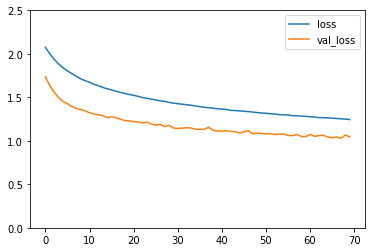

In [13]:
history_df = pd.read_csv("./models/oversampled/effNetB2_oversFullHist.csv")
# history_df = new_entries

history_df.plot(y=['loss', 'val_loss'], ylim=(0, 2.5))

Todas as métricas

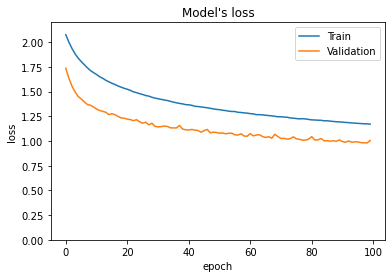

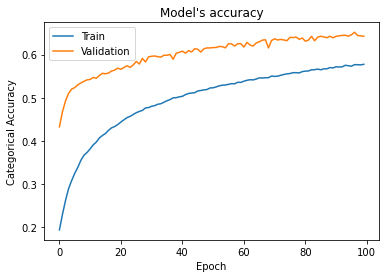

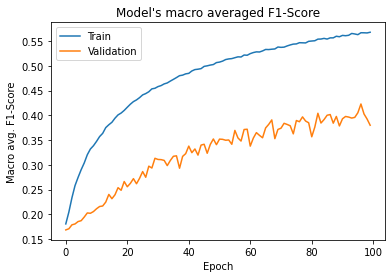

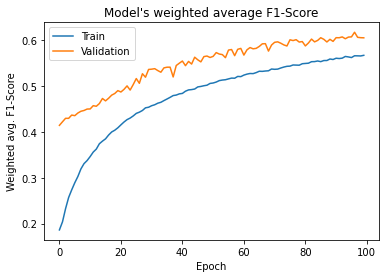

In [34]:
history_df = pd.read_csv("./models/oversampled/effNetB2_oversFullHist.csv")

# Summarize history for loss
plt.plot(history_df['loss'])
plt.plot(history_df['val_loss'])
plt.ylim((0, 2.2))
plt.title('Model\'s loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
print()

# Summarize history for accuracy
plt.plot(history_df['Categorical Accuracy'])
plt.plot(history_df['val_Categorical Accuracy'])
plt.title('Model\'s accuracy')
plt.ylabel('Categorical Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
print()

# Summarize history for MACRO avg. F1-Score
plt.plot(history_df['Macro F1'])
plt.plot(history_df['val_Macro F1'])
plt.title('Model\'s macro averaged F1-Score')
plt.ylabel('Macro avg. F1-Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
print()

# Summarize history for WEIGHTED avg. F1
plt.plot(history_df['Weighted F1'])
plt.plot(history_df['val_Weighted F1'])
plt.title('Model\'s weighted average F1-Score')
plt.ylabel('Weighted avg. F1-Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

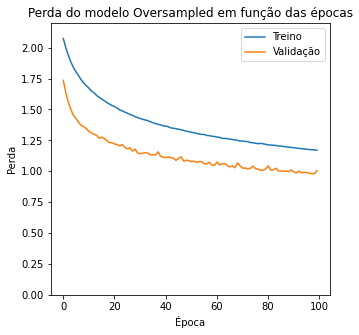

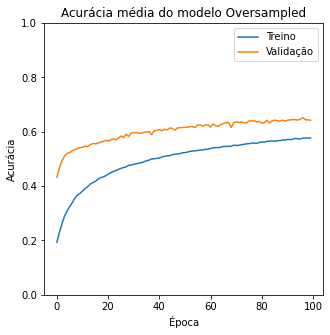

In [36]:
# Summarize history for loss
fig_loss = plt.figure(figsize=(5, 5))
ax_loss  = plt.subplot()
ax_loss.plot(history_df['loss'])
ax_loss.plot(history_df['val_loss'])
plt.ylim((0, 2.2))
plt.title("Perda do modelo Oversampled em função das épocas")
plt.ylabel('Perda')
plt.xlabel('Época')
plt.legend(['Treino', 'Validação'], loc='upper right')

plt.savefig("./figures/overs_loss5.png")

# Summarize history for accuracy
fig_acc = plt.figure(figsize=(5, 5))
ax_acc  = plt.subplot()
ax_acc.plot(history_df['Categorical Accuracy'])
ax_acc.plot(history_df['val_Categorical Accuracy'])
plt.ylim((0, 1))
plt.title("Acurácia média do modelo Oversampled")
plt.ylabel("Acurácia")
plt.xlabel("Época")
plt.legend(['Treino', 'Validação'], loc='upper right')

plt.savefig("./figures/overs_acc5.png")

# # Summarize history for MACRO avg. F1-Score
# fig_f1 = plt.figure(figsize=(5, 5))
# ax_f1 = plt.subplot()
# ax_f1.plot(history_df['Macro F1'])
# ax_f1.plot(history_df['val_Macro F1'])
# plt.title("F1-score médio do modelo")
# plt.ylabel("F1-Score")
# plt.xlabel("Época")
# plt.legend(['Train', 'Validation'], loc='lower right')

# plt.savefig("sgd_f1_5.png")

## Testes

### Nesterov learning rate

#### Conjunto de validação

In [30]:
model = keras.models.load_model(
    "./models/nesterov/effNetB2_nesterovFull47")

In [45]:
# Predicts labels
val_predictions = model.predict(val_generator, verbose=1)

print(classification_report(val_generator.labels.argmax(1),
                            val_predictions.argmax(1), zero_division=0))

159/159 [==============================] - 45s 283ms/step
              precision    recall  f1-score   support

           0       0.17      0.24      0.20       904
           1       0.51      0.50      0.50      2575
           2       0.13      0.11      0.12       665
           3       0.03      0.05      0.04       173
           4       0.12      0.05      0.07       525
           5       0.00      0.00      0.00        48
           6       0.03      0.04      0.04        51
           7       0.02      0.04      0.03       125

    accuracy                           0.32      5066
   macro avg       0.13      0.13      0.12      5066
weighted avg       0.32      0.32      0.32      5066



[Text(0.5, 0, 'MEL'),
 Text(1.5, 0, 'NV'),
 Text(2.5, 0, 'BCC'),
 Text(3.5, 0, 'AK'),
 Text(4.5, 0, 'BKL'),
 Text(5.5, 0, 'DF'),
 Text(6.5, 0, 'VASC'),
 Text(7.5, 0, 'SCC')]

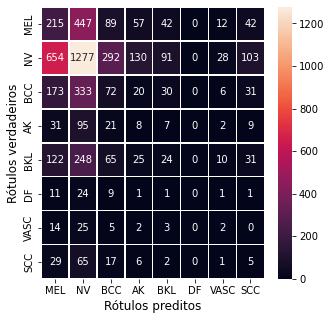

In [46]:
import seaborn as sns

# Confusion matrix
confusion = tf.math.confusion_matrix(val_generator.labels.argmax(1),
                                     val_predictions.argmax(1))

# Confusion matrix (for printing)
confusion_matrix = confusion.numpy()

con_matrix = plt.figure(figsize=(5, 5))
ax_matrix = plt.subplot()

matrix = sns.heatmap(confusion_matrix, annot=True, fmt="d", linewidths=.25)

classes = ["MEL", "NV", "BCC",  "AK", "BKL", "DF", "VASC", "SCC"]

plt.xlabel("Rótulos preditos", fontsize=12)
plt.ylabel('Rótulos verdadeiros', fontsize=12)

ax_matrix.set_yticklabels(classes)
ax_matrix.set_xticklabels(classes)

# plt.savefig("nesterov_val_confusion5.png")

In [47]:
confusion_matrix = confusion.numpy()

FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
TP = np.diag(confusion_matrix)
TN = confusion_matrix.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = np.divide(TP, (TP+FN),
                out=np.zeros(TP.shape, dtype=float),
                where=((TP+FN) != 0))

# Specificity or true negative rate
TNR = np.divide(TN, (TN+FP),
                out=np.zeros(TN.shape, dtype=float),
                where=((TN+FP) != 0))

# Precision or positive predictive value
PPV = np.divide(TP, (TP+FP),
                out=np.zeros(TP.shape, dtype=float),
                where=((TP+FP) != 0))

# Negative predictive value
NPV = np.divide(TN, (TN+FN),
                out=np.zeros(TN.shape, dtype=float),
                where=((TN+FN) != 0))

# Fall out or false positive rate
FPR = np.divide(FP, (FP+TN),
                out=np.zeros(FP.shape, dtype=float),
                where=((FP+TN) != 0))

# False negative rate
FNR = np.divide(FN, (TP+FN),
                out=np.zeros(FN.shape, dtype=float),
                where=((TP+FN) != 0))

# False discovery rate
FDR = np.divide(FP, (TP+FP),
                out=np.zeros(FP.shape, dtype=float),
                where=((TP+FP) != 0))

# Overall accuracy
ACC = np.divide((TP+TN), (TP+FP+FN+TN),
                out=np.zeros((TP+TN).shape, dtype=float),
                where=((TP+FP+FN+TN) != 0))

# c = np.divide(a, b, out=np.zeros_like(a), where=b!=0)
print("True positive:  {}".format(TP))
print("True negative:  {}".format(TN))
print("False positive: {}".format(FP))
print("False negative: {}".format(FN), end="\n\n")

print("Sensibilidade:  {}".format(TPR))
print("Especificidade: {}".format(TNR))
print("Precisão:       {}".format(PPV))
print("Acurácia:       {}".format(ACC))

True positive:  [ 215 1277   72    8   24    0    2    5]
True negative:  [3128 1254 3903 4652 4365 5018 4955 4724]
False positive: [1034 1237  498  241  176    0   60  217]
False negative: [ 689 1298  593  165  501   48   49  120]

Sensibilidade:  [0.23783186 0.49592233 0.10827068 0.04624277 0.04571429 0.
 0.03921569 0.04      ]
Especificidade: [0.75156175 0.50341228 0.8868439  0.95074596 0.96124202 1.
 0.98803589 0.95608176]
Precisão:       [0.17213771 0.50795545 0.12631579 0.03212851 0.12       0.
 0.03225806 0.02252252]
Acurácia:       [0.65988946 0.49960521 0.78464272 0.91985788 0.866364   0.99052507
 0.97848401 0.93347809]


In [50]:
f1_val = 2*(np.mean(TPR) * np.mean(PPV))/(np.mean(TPR) + np.mean(PPV))


print("Médias aritméticas:")
print("Sensibilidade:  {}".format(np.mean(TPR)))
print("Especificidade: {}".format(np.mean(TNR)))
print("Precisão:       {}".format(np.mean(PPV)))
print("F1-score:       {}".format(f1_val))
print("Acurácia:       {}".format(np.mean(ACC)))

Médias aritméticas:
Sensibilidade:  0.12664970146889573
Especificidade: 0.8747404463052997
Precisão:       0.1266647562774489
F1-score:       0.12665722842580884
Acurácia:       0.8291058033951835


#### Conjunto de teste

In [51]:
# Predicts labels
test_predictions = model.predict(test_generator, verbose=1)

print(classification_report(test_generator.labels.argmax(1),
                            test_predictions.argmax(1), zero_division=0))

80/80 [==============================] - 23s 286ms/step
              precision    recall  f1-score   support

           0       0.17      0.23      0.19       453
           1       0.50      0.48      0.49      1288
           2       0.11      0.11      0.11       332
           3       0.02      0.03      0.03        87
           4       0.15      0.05      0.08       262
           5       0.00      0.00      0.00        24
           6       0.00      0.00      0.00        25
           7       0.03      0.05      0.04        63

    accuracy                           0.31      2534
   macro avg       0.12      0.12      0.12      2534
weighted avg       0.32      0.31      0.31      2534



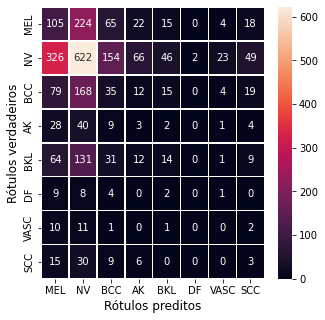

In [52]:
import seaborn as sns

# Confusion matrix
confusion = tf.math.confusion_matrix(test_generator.labels.argmax(1),
                                     test_predictions.argmax(1))

# Confusion matrix (for printing)
confusion_matrix = confusion.numpy()

con_matrix = plt.figure(figsize=(5, 5))
ax_matrix = plt.subplot()

matrix = sns.heatmap(confusion_matrix, annot=True, fmt="d", linewidths=.25)

classes = ["MEL", "NV", "BCC",  "AK", "BKL", "DF", "VASC", "SCC"]

plt.xlabel("Rótulos preditos", fontsize=12)
plt.ylabel('Rótulos verdadeiros', fontsize=12)

ax_matrix.set_yticklabels(classes)
ax_matrix.set_xticklabels(classes)

# plt.savefig("nesterov_test_confusion5.png")

In [53]:
confusion_matrix = confusion.numpy()

FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
TP = np.diag(confusion_matrix)
TN = confusion_matrix.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = np.divide(TP, (TP+FN),
                out=np.zeros(TP.shape, dtype=float),
                where=((TP+FN) != 0))

# Specificity or true negative rate
TNR = np.divide(TN, (TN+FP),
                out=np.zeros(TN.shape, dtype=float),
                where=((TN+FP) != 0))

# Precision or positive predictive value
PPV = np.divide(TP, (TP+FP),
                out=np.zeros(TP.shape, dtype=float),
                where=((TP+FP) != 0))

# Negative predictive value
NPV = np.divide(TN, (TN+FN),
                out=np.zeros(TN.shape, dtype=float),
                where=((TN+FN) != 0))

# Fall out or false positive rate
FPR = np.divide(FP, (FP+TN),
                out=np.zeros(FP.shape, dtype=float),
                where=((FP+TN) != 0))

# False negative rate
FNR = np.divide(FN, (TP+FN),
                out=np.zeros(FN.shape, dtype=float),
                where=((TP+FN) != 0))

# False discovery rate
FDR = np.divide(FP, (TP+FP),
                out=np.zeros(FP.shape, dtype=float),
                where=((TP+FP) != 0))

# Overall accuracy
ACC = np.divide((TP+TN), (TP+FP+FN+TN),
                out=np.zeros((TP+TN).shape, dtype=float),
                where=((TP+FP+FN+TN) != 0))

# c = np.divide(a, b, out=np.zeros_like(a), where=b!=0)
print("True positive:  {}".format(TP))
print("True negative:  {}".format(TN))
print("False positive: {}".format(FP))
print("False negative: {}".format(FN), end="\n\n")

print("Sensibilidade:  {}".format(TPR))
print("Especificidade: {}".format(TNR))
print("Precisão:       {}".format(PPV))
print("Acurácia:       {}".format(ACC))

True positive:  [105 622  35   3  14   0   0   3]
True negative:  [1550  634 1929 2329 2191 2508 2475 2370]
False positive: [531 612 273 118  81   2  34 101]
False negative: [348 666 297  84 248  24  25  60]

Sensibilidade:  [0.23178808 0.48291925 0.10542169 0.03448276 0.05343511 0.
 0.         0.04761905]
Especificidade: [0.74483421 0.50882825 0.8760218  0.95177769 0.96434859 0.99920319
 0.98644878 0.95912586]
Precisão:       [0.16509434 0.50405186 0.11363636 0.02479339 0.14736842 0.
 0.         0.02884615]
Acurácia:       [0.6531176  0.49565904 0.77505919 0.92028414 0.87016575 0.98973954
 0.97671665 0.93646409]


In [54]:
f1_test = 2*(np.mean(TPR) * np.mean(PPV))/(np.mean(TPR) + np.mean(PPV))

print("Médias aritméticas:")
print("Sensibilidade:  {}".format(np.mean(TPR)))
print("Especificidade: {}".format(np.mean(TNR)))
print("Precisão:       {}".format(np.mean(PPV)))
print("F1-score:       {}".format(f1_test))
print("Acurácia:       {}".format(np.mean(ACC)))

Médias aritméticas:
Sensibilidade:  0.11945824270239072
Especificidade: 0.8738235466502913
Precisão:       0.12297381630561464
F1-score:       0.12119053935676256
Acurácia:       0.8271507498026835


### Oversampled

In [24]:
model = keras.models.load_model(
    "./models/oversampled/effNetB2_oversFull99")

#### Validação

In [ ]:
# Predicts labels
val_predictions = model.predict(val_generator, verbose=1)

print(classification_report(val_generator.labels.argmax(1),
                            val_predictions.argmax(1), zero_division=0))

 39/159 [======>.......................] - ETA: 30s

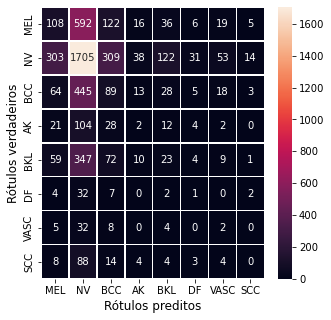

In [38]:
import seaborn as sns

# Confusion matrix
confusion = tf.math.confusion_matrix(val_generator.labels.argmax(1),
                                     val_predictions.argmax(1))

# Confusion matrix (for printing)
confusion_matrix = confusion.numpy()

con_matrix = plt.figure(figsize=(5, 5))
ax_matrix = plt.subplot()

matrix = sns.heatmap(confusion_matrix, annot=True, fmt="d", linewidths=.25)

classes = ["MEL", "NV", "BCC",  "AK", "BKL", "DF", "VASC", "SCC"]

plt.xlabel("Rótulos preditos", fontsize=12)
plt.ylabel('Rótulos verdadeiros', fontsize=12)

ax_matrix.set_yticklabels(classes)
ax_matrix.set_xticklabels(classes)

plt.savefig("./figures/overs_validation_confusion5.png")

In [27]:
# Per class metrics

FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
TP = np.diag(confusion_matrix)
TN = confusion_matrix.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = np.divide(TP, (TP+FN),
                out=np.zeros(TP.shape, dtype=float),
                where=((TP+FN) != 0))

# Specificity or true negative rate
TNR = np.divide(TN, (TN+FP),
                out=np.zeros(TN.shape, dtype=float),
                where=((TN+FP) != 0))

# Precision or positive predictive value
PPV = np.divide(TP, (TP+FP),
                out=np.zeros(TP.shape, dtype=float),
                where=((TP+FP) != 0))

# Negative predictive value
NPV = np.divide(TN, (TN+FN),
                out=np.zeros(TN.shape, dtype=float),
                where=((TN+FN) != 0))

# Fall out or false positive rate
FPR = np.divide(FP, (FP+TN),
                out=np.zeros(FP.shape, dtype=float),
                where=((FP+TN) != 0))

# False negative rate
FNR = np.divide(FN, (TP+FN),
                out=np.zeros(FN.shape, dtype=float),
                where=((TP+FN) != 0))

# False discovery rate
FDR = np.divide(FP, (TP+FP),
                out=np.zeros(FP.shape, dtype=float),
                where=((TP+FP) != 0))

# Overall accuracy
ACC = np.divide((TP+TN), (TP+FP+FN+TN),
                out=np.zeros((TP+TN).shape, dtype=float),
                where=((TP+FP+FN+TN) != 0))

# F1-score
F1 = 2*np.divide(np.multiply(TPR, PPV), (TPR+PPV),
                 out=np.zeros(dividend.shape, dtype=float),
                 where=(divisor != 0))

print("True positive:  {}".format(TP))
print("True negative:  {}".format(TN))
print("False positive: {}".format(FP))
print("False negative: {}".format(FN), end="\n\n")

print("Sensibilidade:  {}".format(TPR))
print("Especificidade: {}".format(TNR))
print("Precisão:       {}".format(PPV))
print("F1-score:       {}".format(F1))
print("Acurácia:       {}".format(ACC))

True positive:  [  85 1707   84    1   17    1    2    3]
True negative:  [3675  853 3836 4811 4327 4965 4910 4919]
False positive: [ 487 1638  565   82  214   53  105   22]
False negative: [819 868 581 172 508  47  49 122]

Sensibilidade:  [0.09402655 0.66291262 0.12631579 0.00578035 0.03238095 0.02083333
 0.03921569 0.024     ]
Especificidade: [0.88298895 0.34243276 0.87162009 0.98324137 0.95287382 0.98943802
 0.97906281 0.99554746]
Precisão:       [0.1486014  0.5103139  0.12942989 0.01204819 0.07359307 0.01851852
 0.01869159 0.12      ]
F1-score:       [0.11517615 0.57668919 0.12785388 0.0078125  0.04497354 0.
 0.         0.        ]
Acurácia:       [0.74220292 0.50532965 0.77378602 0.94986182 0.85748125 0.98026056
 0.96960126 0.97157521]


In [28]:
# Averaged metrics

print("Médias aritméticas:")
print("Sensibilidade:  {}".format(np.mean(TPR)))
print("Especificidade: {}".format(np.mean(TNR)))
print("Precisão:       {}".format(np.mean(PPV)))
print("F1-score:       {}".format(np.mean(F1)))
print("Acurácia:       {}".format(np.mean(ACC)))

Médias aritméticas:
Sensibilidade:  0.12568315978938482
Especificidade: 0.8746506585199921
Precisão:       0.1288995707195212
F1-score:       0.10906315840034883
Acurácia:       0.843762337149625


#### Teste

In [39]:
# Predicts labels
test_predictions = model.predict(test_generator, verbose=1)

print(classification_report(test_generator.labels.argmax(1),
                            test_predictions.argmax(1), zero_division=0))

80/80 [==============================] - 21s 258ms/step
              precision    recall  f1-score   support

           0       0.18      0.12      0.15       453
           1       0.50      0.64      0.56      1288
           2       0.10      0.10      0.10       332
           3       0.03      0.02      0.03        87
           4       0.09      0.03      0.05       262
           5       0.00      0.00      0.00        24
           6       0.04      0.08      0.05        25
           7       0.00      0.00      0.00        63

    accuracy                           0.37      2534
   macro avg       0.12      0.13      0.12      2534
weighted avg       0.31      0.37      0.33      2534



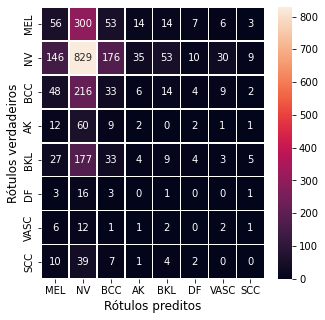

In [40]:
import seaborn as sns

# Confusion matrix
confusion = tf.math.confusion_matrix(test_generator.labels.argmax(1),
                                     test_predictions.argmax(1))

# Confusion matrix (for printing)
confusion_matrix = confusion.numpy()

con_matrix = plt.figure(figsize=(5, 5))
ax_matrix = plt.subplot()

matrix = sns.heatmap(confusion_matrix, annot=True, fmt="d", linewidths=.25)

classes = ["MEL", "NV", "BCC",  "AK", "BKL", "DF", "VASC", "SCC"]

plt.xlabel("Rótulos preditos", fontsize=12)
plt.ylabel('Rótulos verdadeiros', fontsize=12)

ax_matrix.set_yticklabels(classes)
ax_matrix.set_xticklabels(classes)

plt.savefig("./figures/overs_test_confusion5.png")

In [41]:
# Per class metrics

FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
TP = np.diag(confusion_matrix)
TN = confusion_matrix.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = np.divide(TP, (TP+FN),
                out=np.zeros(TP.shape, dtype=float),
                where=((TP+FN) != 0))

# Specificity or true negative rate
TNR = np.divide(TN, (TN+FP),
                out=np.zeros(TN.shape, dtype=float),
                where=((TN+FP) != 0))

# Precision or positive predictive value
PPV = np.divide(TP, (TP+FP),
                out=np.zeros(TP.shape, dtype=float),
                where=((TP+FP) != 0))

# Negative predictive value
NPV = np.divide(TN, (TN+FN),
                out=np.zeros(TN.shape, dtype=float),
                where=((TN+FN) != 0))

# Fall out or false positive rate
FPR = np.divide(FP, (FP+TN),
                out=np.zeros(FP.shape, dtype=float),
                where=((FP+TN) != 0))

# False negative rate
FNR = np.divide(FN, (TP+FN),
                out=np.zeros(FN.shape, dtype=float),
                where=((TP+FN) != 0))

# False discovery rate
FDR = np.divide(FP, (TP+FP),
                out=np.zeros(FP.shape, dtype=float),
                where=((TP+FP) != 0))

# Overall accuracy
ACC = np.divide((TP+TN), (TP+FP+FN+TN),
                out=np.zeros((TP+TN).shape, dtype=float),
                where=((TP+FP+FN+TN) != 0))

# F1-score
F1 = 2*np.divide(np.multiply(TPR, PPV), (TPR+PPV),
                 out=np.zeros(dividend.shape, dtype=float),
                 where=(divisor != 0))

# c = np.divide(a, b, out=np.zeros_like(a), where=b!=0)
print("True positive:  {}".format(TP))
print("True negative:  {}".format(TN))
print("False positive: {}".format(FP))
print("False negative: {}".format(FN), end="\n\n")

print("Sensibilidade:  {}".format(TPR))
print("Especificidade: {}".format(TNR))
print("Precisão:       {}".format(PPV))
print("F1-score:       {}".format(F1))
print("Acurácia:       {}".format(ACC))

True positive:  [ 56 829  33   2   9   0   2   0]
True negative:  [1829  426 1920 2386 2184 2481 2460 2449]
False positive: [252 820 282  61  88  29  49  22]
False negative: [397 459 299  85 253  24  23  63]

Sensibilidade:  [0.12362031 0.64363354 0.09939759 0.02298851 0.03435115 0.
 0.08       0.        ]
Especificidade: [0.87890437 0.34189406 0.8719346  0.97507152 0.96126761 0.98844622
 0.98047031 0.99109672]
Precisão:       [0.18181818 0.50272893 0.1047619  0.03174603 0.09278351 0.
 0.03921569 0.        ]
F1-score:       [0.14717477 0.56452162 0.10200927 0.02666667 0.05013928 0.
 0.         0.        ]
Acurácia:       [0.74388319 0.4952644  0.77071823 0.94238358 0.86543015 0.97908445
 0.97158642 0.9664562 ]


In [42]:
# Averaged metrics

print("Médias aritméticas:")
print("Sensibilidade:  {}".format(np.mean(TPR)))
print("Especificidade: {}".format(np.mean(TNR)))
print("Precisão:       {}".format(np.mean(PPV)))
print("F1-score:       {}".format(np.mean(F1)))
print("Acurácia:       {}".format(np.mean(ACC)))

Médias aritméticas:
Sensibilidade:  0.12549888632127296
Especificidade: 0.873635675572876
Precisão:       0.11913177954718282
F1-score:       0.11131395084297821
Acurácia:       0.8418508287292819


### Modelo p/ copiar e colar

*   Batch size: 32;
*   Topo treinado por XX épocas;
*   Número de épocas de treinamento: YY;
*   *Learning rate*: ZZ;

In [ ]:
# # Load model
# model = keras.models.load_model("path/to/model")

In [27]:
# # Predicts labels
# test_predictions = model.predict(test_generator, verbose=1)

# print(classification_report(test_generator.labels.argmax(1),
#                             test_predictions.argmax(1), zero_division=0))

In [27]:
# import seaborn as sns

# # Confusion matrix
# confusion = tf.math.confusion_matrix(test_generator.labels.argmax(1),
#                                      test_predictions.argmax(1))

# # Confusion matrix (for printing)
# confusion_matrix = confusion.numpy()

# con_matrix = plt.figure(figsize=(5, 5))
# ax_matrix = plt.subplot()

# matrix = sns.heatmap(confusion_matrix, annot=True, fmt="d", linewidths=.25)

# classes = ["MEL", "NV", "BCC",  "AK", "BKL", "DF", "VASC", "SCC"]

# plt.xlabel("Rótulos preditos", fontsize=12)
# plt.ylabel('Rótulos verdadeiros', fontsize=12)

# ax_matrix.set_yticklabels(classes)
# ax_matrix.set_xticklabels(classes)

# # plt.savefig("nesterov_test_confusion5.png")

In [28]:
# # Per class metrics

# FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
# FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
# TP = np.diag(confusion_matrix)
# TN = confusion_matrix.sum() - (FP + FN + TP)

# # Sensitivity, hit rate, recall, or true positive rate
# TPR = np.divide(TP, (TP+FN),
#                 out=np.zeros(TP.shape, dtype=float),
#                 where=((TP+FN) != 0))

# # Specificity or true negative rate
# TNR = np.divide(TN, (TN+FP),
#                 out=np.zeros(TN.shape, dtype=float),
#                 where=((TN+FP) != 0))

# # Precision or positive predictive value
# PPV = np.divide(TP, (TP+FP),
#                 out=np.zeros(TP.shape, dtype=float),
#                 where=((TP+FP) != 0))

# # Negative predictive value
# NPV = np.divide(TN, (TN+FN),
#                 out=np.zeros(TN.shape, dtype=float),
#                 where=((TN+FN) != 0))

# # Fall out or false positive rate
# FPR = np.divide(FP, (FP+TN),
#                 out=np.zeros(FP.shape, dtype=float),
#                 where=((FP+TN) != 0))

# # False negative rate
# FNR = np.divide(FN, (TP+FN),
#                 out=np.zeros(FN.shape, dtype=float),
#                 where=((TP+FN) != 0))

# # False discovery rate
# FDR = np.divide(FP, (TP+FP),
#                 out=np.zeros(FP.shape, dtype=float),
#                 where=((TP+FP) != 0))

# # Overall accuracy
# ACC = np.divide((TP+TN), (TP+FP+FN+TN),
#                 out=np.zeros((TP+TN).shape, dtype=float),
#                 where=((TP+FP+FN+TN) != 0))

# # F1-score
# F1 = 2*np.divide(np.multiply(TPR, PPV), (TPR+PPV),
#                  out=np.zeros(dividend.shape, dtype=float),
#                  where=(divisor != 0))

# # c = np.divide(a, b, out=np.zeros_like(a), where=b!=0)
# print("True positive:  {}".format(TP))
# print("True negative:  {}".format(TN))
# print("False positive: {}".format(FP))
# print("False negative: {}".format(FN), end="\n\n")

# print("Sensibilidade:  {}".format(TPR))
# print("Especificidade: {}".format(TNR))
# print("Precisão:       {}".format(PPV))
# print("F1-score:       {}".format(F1))
# print("Acurácia:       {}".format(ACC))

In [ ]:
# # Averaged metrics

# print("Médias aritméticas:")
# print("Sensibilidade:  {}".format(np.mean(TPR)))
# print("Especificidade: {}".format(np.mean(TNR)))
# print("Precisão:       {}".format(np.mean(PPV)))
# print("F1-score:       {}".format(np.mean(F1)))
# print("Acurácia:       {}".format(np.mean(ACC)))